## Install packages

In [3]:
%%capture
%pip install --upgrade transformers
%pip install wget
%pip install -U git+https://github.com/huggingface/transformers.git
%pip install -U git+https://github.com/huggingface/accelerate.git
%pip install spacy
%pip install pyspellchecker

## Load packages

In [4]:
import json, os, wget, tarfile, zipfile, requests, wandb, torch, optuna
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import matplotlib.pyplot as plt
from optuna.samplers import TPESampler
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import BlipProcessor, BlipForQuestionAnswering
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from transformers.tokenization_utils_base import BatchEncoding
import pandas as pd, numpy as np, torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from sklearn.utils import shuffle
from torch.optim import AdamW
from torch.nn import DataParallel
from tqdm.notebook import tqdm
import PIL, torchvision, random
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 2.0.0
Torchvision version: 0.15.1


## Download functions

The functions `download_and_extract()` and `download_and_extract_tar()` are used to download and extract compressed data files. 

In [6]:
def download_and_extract(data_url, zip_path):
    wget.download(data_url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

def download_and_extract_tar(data_url, tar_path):
    wget.download(data_url, tar_path)
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall()

In [7]:
# ---------------------------------------------#
# Data from: https://visualqa.org/download.html
# ---------------------------------------------#

# # Download and extract the training images
# download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/scene_img/scene_img_abstract_v002_binary_train2017.zip",
#                      "scene_img_abstract_v002_binary_train2017.zip")

# # Download the training questions
# download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Questions_Binary_Train2017_abstract_v002.zip",
#                      "Questions_Binary_Train2017_abstract_v002.zip")

# # Download the training annotations
# download_and_extract("https://s3.amazonaws.com/cvmlp/vqa/abstract_v002/vqa/Annotations_Binary_Train2017_abstract_v002.zip",
#                      "Annotations_Binary_Train2017_abstract_v002.zip")

# ---------------------------------------------#
#          Validation Simpsons Data
# ---------------------------------------------#

# Download and extract the validation images
download_and_extract_tar("http://206.12.93.90:8080/simpson2022_dataset/simpsons_validation.tar.gz",
                     "simpsons_validation.tar.gz")

# Download the validation questions
download_and_extract("http://206.12.93.90:8080/simpson2022_dataset/questions_validation.zip",
                     "questions_validation.zip")

# Download the validation annotations
download_and_extract("http://206.12.93.90:8080/simpson2022_dataset/annotations_validation.zip",
                     "annotations_validation.zip")

# Filtering function 

From forked notebook - https://github.com/rbouadjenek/deakin-ai-challenge2023/blob/main/deakin_ai_challenge_tdeakin_ai_challenge_training.ipynb

In [8]:
def filter_questions(questions, annotations, imgs_path, train_type, train):
    '''
    Filter questions for which the answers are not in the set of possible answers.
    '''
    # Make sure the questions and annotations are alligned
    questions['questions'] = sorted(questions['questions'], key=lambda x: x['question_id'])
    annotations['annotations'] = sorted(annotations['annotations'], key=lambda x: x['question_id'])
    q_out = []
    anno_out = []
    imgs_out = []
    q_ids = []
    question_ids_set = set()
    # Filter annotations
    for annotation in annotations['annotations']:
        if annotation['multiple_choice_answer'] in ['yes','no']:
            question_ids_set.add(annotation['question_id'])
            q_ids.append(annotation['question_id'])
            anno_out.append(annotation['multiple_choice_answer'])
    # Filter images and questions
    for q in questions['questions']:
        if q['question_id'] in question_ids_set:
            # Preprocessing the question
            q_text = q['question'].lower()
            q_text = q_text.replace('?', ' ? ')
            q_text = q_text.replace('.', ' . ')
            q_text = q_text.replace(',', ' . ')
            q_text = q_text.replace('!', ' . ').strip()
            q_out.append(q_text)
            file_name = str(q['image_id'])
            while len(file_name) != 12:
                file_name = '0' + file_name
            if train:
                file_name = imgs_path + questions['data_type'] + '_' + f"{train_type}2015" + '_' + file_name + '.png'
            else:
                file_name = imgs_path + questions['data_type'] + '_' + questions['data_subtype'] + '_' + file_name + '.png'
            imgs_out.append(file_name)
    return imgs_out, q_out, anno_out, q_ids

In [9]:
def preprocess_data(questions, annotations, image_paths, train_type, train, shuffle_data=True):
    # Filter questions based on train type and availability of corresponding image paths
    images, questions, annotations, question_ids = filter_questions(questions, annotations, image_paths, train_type, train)

    if shuffle_data:
        # Shuffle the data if required
        images, questions, annotations, question_ids = shuffle(images, questions, annotations, question_ids, random_state=0)

    # Return preprocessed data
    return images, questions, annotations, question_ids

In [83]:
# # # Read training data
# q_train = json.load(open('/kaggle/input/binary-balanced-vqa/Questions_Binary_Train2017_abstract_v002/OpenEnded_abstract_v002_train2017_questions.json'))
# anno_train = json.load(open('/kaggle/input/binary-balanced-vqa/Annotations_Binary_Train2017_abstract_v002/abstract_v002_train2017_annotations.json'))
# imgs_train = "/kaggle/working/scene_img_abstract_v002_train2017/"

# Read validation data
q_val = json.load(open('/kaggle/working/questions_validation.json'))
anno_val = json.load(open('/kaggle/working/annotations_validation.json'))
imgs_val = "/kaggle/working/simpsons_validation/"

In [84]:
# # Training
# imgs_train, q_train, anno_train, q_ids_train = preprocess_data(q_train, anno_train, imgs_train, 'train', train=True, shuffle_data=False)

# Validation
imgs_val, q_val, anno_val, q_ids_val = preprocess_data(q_val, anno_val, imgs_val, 'val', train=False, shuffle_data=False)

## Data Augmentation functions

Same as previous winner from last years challenge - with a few changes. 
 - https://github.com/JessieHex/SimpsonsVQA/blob/main/vqa.ipynb

In [12]:
# Apply Shear transformation along the x-axis
def ShearX(img, v):
    assert -0.3 <= v <= 0.3
    v = -v if random.random() > 0.5 else v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

# Apply Shear transformation along the y-axis
def ShearY(img, v):
    assert -0.3 <= v <= 0.3
    v = -v if random.random() > 0.5 else v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

# Apply Rotate transformation
def Rotate(img, v):
    assert -30 <= v <= 30
    v = -v if random.random() > 0.5 else v
    return img.rotate(v)

# Adjust image brightness
def Brightness(img, v):
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

# Adjust image sharpness
def Sharpness(img, v):
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

# Apply translation along the x-axis
def TranslateXabs(img, v):
    assert 0 <= v
    v = -v if random.random() > 0.5 else v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

# Apply translation along the y-axis
def TranslateYabs(img, v):
    assert 0 <= v
    v = -v if random.random() > 0.5 else v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

# Apply Cutout transformation
def CutoutAbs(img, v):
    if v < 0:
        return img
    w, h = img.size
    x0 = int(max(0, np.random.uniform(w) - v / 2.0))
    y0 = int(max(0, np.random.uniform(h) - v / 2.0))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img

# Defining the image transformations
def augment_list():
    return [
        (Rotate, 0, 25),
        (ShearX, 0.0, 0.9),
        (ShearY, 0.0, 0.9),
        (CutoutAbs, 0, 80),
        (TranslateXabs, 0.0, 20),
        (TranslateYabs, 0.0, 20),
    ]

# Implementation of RandAugment
class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m  
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)
        return img

# Defining the overall transformation pipeline
def pixelbert_transform_randaug():
    trs = transforms.Compose(
        [
            RandAugment(2, 9),
            transforms.ToTensor(),
        ]
    )
    return trs

# Instantiate the transformation pipeline
trs = pixelbert_transform_randaug()

## With Data Augmentation

In [13]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, images, questions, annotations, processor, trs):
        self.images = images
        self.questions = questions
        self.annotations = annotations
        self.processor = processor
        self.transforms = trs

    def __len__(self):
        # Return the length of the dataset (number of questions)
        return len(self.questions)

    def __getitem__(self, idx):
        # Open and convert the image to RGB format
        img = Image.open(self.images[idx]).convert("RGB")
        img = img.resize((256, 256))
        img = self.transforms(img)

        # Process the question and encode it
        encoding = self.processor(
            images=img,
            text=self.questions[idx],
            padding="max_length",
            truncation=True,
            return_tensors="pt")
        
        item = {key: val.squeeze() for key, val in encoding.items()}

        # Process the annotation and obtain the labels
        labels = self.processor(
            text=self.annotations[idx],
            return_tensors="pt"
        ).input_ids.squeeze(0)

        # Add the labels to the item
        item['labels'] = labels

        return item

## Without Data Augmentation

In [14]:
class VQADatasetWithoutAugmentation(torch.utils.data.Dataset):
    def __init__(self, images, questions, annotations, processor):
        self.images = images
        self.questions = questions
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        # Return the length of the dataset (number of annotations)
        return len(self.annotations)

    def __getitem__(self, idx):
        # Open and convert the image to RGB format
        img = Image.open(self.images[idx]).convert("RGB")
        img = img.resize((256, 256))

        # Process the question and encode it
        encoding = self.processor(
            images=img,
            text=self.questions[idx],
            padding="max_length",
            truncation=True,
            return_tensors="pt")
        
        item = {key: val.squeeze() for key, val in encoding.items()}

        # Process the annotation and obtain the labels
        labels = self.processor(
            text=self.annotations[idx],
            return_tensors="pt"
        ).input_ids.squeeze(0)

        # Add the labels to the item
        item['labels'] = labels

        return item

## Other functions

In [15]:
def model_init():
     # Load the pre-trained model with the original configuration
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base") 
    return model

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    
    # Convert logits to probabilities and then to class labels
    preds = (sigmoid(preds[0]) > 0.5).astype(int)
    
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc}

## Load Pre-trained Model and Data for Training

In [16]:
# processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-capfilt-large")
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-capfilt-large").to("cuda")

In [17]:
# Load base model again
wandb.init()
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
path = wandb.use_artifact("usedpython/uncategorized/deakin-ai-blip-submission:v1").download()
model = torch.load(path + "/model.pth", map_location=torch.device('cuda')) 

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact deakin-ai-blip-submission:v1, 1467.78MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:23.4


In [18]:
def generate_new_train_subset(imgs_train, q_train, anno_train):
    # Select 1000 random indices from training data
    train_indices = np.random.choice(len(imgs_train), size=len(q_train), replace=False)

    # Use these indices to create the new training subset
    subset_imgs = imgs_train[train_indices]
    subset_q = q_train[train_indices]
    subset_anno = anno_train[train_indices]

    # Create a new VQADataset with this subset
    train_subset = VQADatasetWithoutAugmentation(subset_imgs, subset_q, subset_anno, processor)

    return train_subset

In [19]:
# # Convert to numpy array 
# imgs_train = np.array(imgs_train)
# q_train = np.array(q_train)
# anno_train = np.array(anno_train)

# # Training Model
# train_subset = generate_new_train_subset(imgs_train,q_train,anno_train)

In [85]:
# Convert to numpy array 
imgs_val = np.array(imgs_val)
q_val = np.array(q_val)
anno_val = np.array(anno_val)

# Validation Model
val_model = VQADatasetWithoutAugmentation(imgs_val, q_val, anno_val, processor)

## Hyperparameter Search

In [27]:
# def optuna_hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
#         "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
#     }

# training_args = TrainingArguments(
#     max_steps=250,  
#     output_dir="./results",
#     per_device_train_batch_size=6,  
#     per_device_eval_batch_size=4,  
#     warmup_steps=50,
#     remove_unused_columns=True,
#     report_to="wandb",
#     evaluation_strategy = "steps",
#     load_best_model_at_end=False, 
#     metric_for_best_model="loss",
#     greater_is_better=False,
#     eval_steps=250,
#     save_strategy="no", 
# )

# # Define the Trainer and launch the hyperparameter search
# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=train_subset,
#     eval_dataset=val_model,
# )

# # Use the created study for hyperparameter search
# best_run = trainer.hyperparameter_search(n_trials=20, 
#                                          direction="minimize", 
#                                          backend="optuna",
#                                          sampler=TPESampler(n_startup_trials=3),
#                                          hp_space=optuna_hp_space)

# # Output the best hyperparameters
# print(best_run)

# for n, v in best_run.hyperparameters.items():
#     setattr(trainer.args, n, v)

# trainer.train()

## Train Model (VQA dataset)

In [28]:
# # Delete to make more room
# os.remove("/kaggle/working/scene_img_abstract_v002_binary_train2017.zip")

In [29]:
# Best params for model
params = {'learning_rate': 2e-5, 'weight_decay': 0.05}

num_epochs = 2
train_dataset_size = len(train_subset)  
train_batch_size = 2

# Calculate the number of training steps and warmup steps
num_training_steps = num_epochs * (train_dataset_size // train_batch_size)
num_warmup_steps = int(0.1 * num_training_steps)

# Create optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Define the training args
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=1,
    warmup_steps=num_warmup_steps,
    learning_rate=params['learning_rate'],
    evaluation_strategy="epoch",
    save_strategy="no",
    load_best_model_at_end=False,
    metric_for_best_model="loss",
    greater_is_better=False
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, lr_scheduler)
)

trainer.train()

## Save Model

In [22]:
# torch.save(model, 'model.pth')
# wandb.save("model.pth")
# art = wandb.Artifact(f'deakin-ai-blip-submission_new', type="model")
# art.add_file("model.pth", "model.pth")
# wandb.log_artifact(art)

## Load and pre-process data for further training then testing 

In [86]:
def read_file(file_path, csv=True):
    """Function to read a CSV or Excel file."""
    return pd.read_csv(file_path) if csv else pd.read_excel(file_path)

def update_image_paths(data, folder_path):
    """Function to update image paths in the given data using the specified folder path."""
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith(".png"):
            image_id = int(filename.split("_")[-1].split(".")[0])
            if image_id in data['Image ID'].values:
                data.loc[data['Image ID'] == image_id, 'Image File'] = file_path

    for image_id in data['Image ID']:
        for ext in ['jpg', 'jpeg', 'png']:
            image_file = f"{image_id}.{ext}"
            image_path = os.path.join(folder_path, image_file)
            if os.path.isfile(image_path):
                data.loc[data['Image ID'] == image_id, 'Image File'] = image_path

    return data

def encode_labels(data):
    """Function to encode labels in the given data."""
    data['Answer'] = np.where(data['Answer'] == 'yes', 1, 0)
    return data

def pre_process(path, csv=True):
    """Function to pre-process data."""
    data = read_file(path, csv)
    data = update_image_paths(data, folder_path)
    data['Question'] = data['Question'].str.lower()
    data['Answer'] = data['Answer'].str.lower()
    data = data.dropna().reset_index(drop=True)
    return data

In [13]:
# # Define folder paths
# folder_path = "/kaggle/input/simp-data/Simpsons Train Data/Simpsons Train Data" # My own dataset
# folder_path_2 = "/kaggle/input/simp-data/simpsons_validation" # Dataset created by team at Deakin AI

# # Load data
# train = pre_process('/kaggle/input/simp-data/train_data.csv',True)
# test = pre_process('/kaggle/input/simp-data/test_data.xlsx',False)

In [87]:
# # Training
# train_dataset = VQADatasetWithoutAugmentation(train['Image File'], train['Question'], train['Answer'], processor)

# # Testing
# test_dataset = VQADatasetWithoutAugmentation(test['Image File'], test['Question'], test['Answer'], processor)
test_dataloader = DataLoader(val_model, batch_size=1)

## Train Model (Simpsons dataset)

In [31]:
# # Best params for model
# params = {'learning_rate': 2e-4, 'weight_decay': 0.001}

# num_epochs = 3
# train_dataset_size = len(train_dataset)  
# train_batch_size = 2

# # Calculate the number of training steps and warmup steps
# num_training_steps = num_epochs * (train_dataset_size // train_batch_size)
# num_warmup_steps = int(0.1 * num_training_steps)

# # Create optimizer and learning rate scheduler
# optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
# lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=num_warmup_steps,
#     num_training_steps=num_training_steps
# )

# # Define the training args
# training_args = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=num_epochs,
#     per_device_train_batch_size=train_batch_size,
#     per_device_eval_batch_size=1,
#     warmup_steps=num_warmup_steps,
#     learning_rate=params['learning_rate'],
#     evaluation_strategy="epoch",
#     save_strategy="no",
#     load_best_model_at_end=False,
#     metric_for_best_model="loss",
#     greater_is_better=False
# )

# # Create the trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     optimizers=(optimizer, lr_scheduler)
# )

# trainer.train()

## Testing Model

In [88]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 
model.eval()

y_predict = []

with torch.no_grad():
    for local_batch in test_dataloader:
        local_batch = BatchEncoding(local_batch)
        local_batch.to(device)
        outputs = model.generate(**local_batch)
        pred = processor.decode(outputs[0], skip_special_tokens=True)
        y_predict.append(pred) 

y_predict = np.array(y_predict)

In [93]:
# Calculate accuracy
accuracy = accuracy_score(anno_val, y_predict)
print('Accuracy:', round(accuracy,3)*100)

Accuracy: 83.3


## Error Analysis

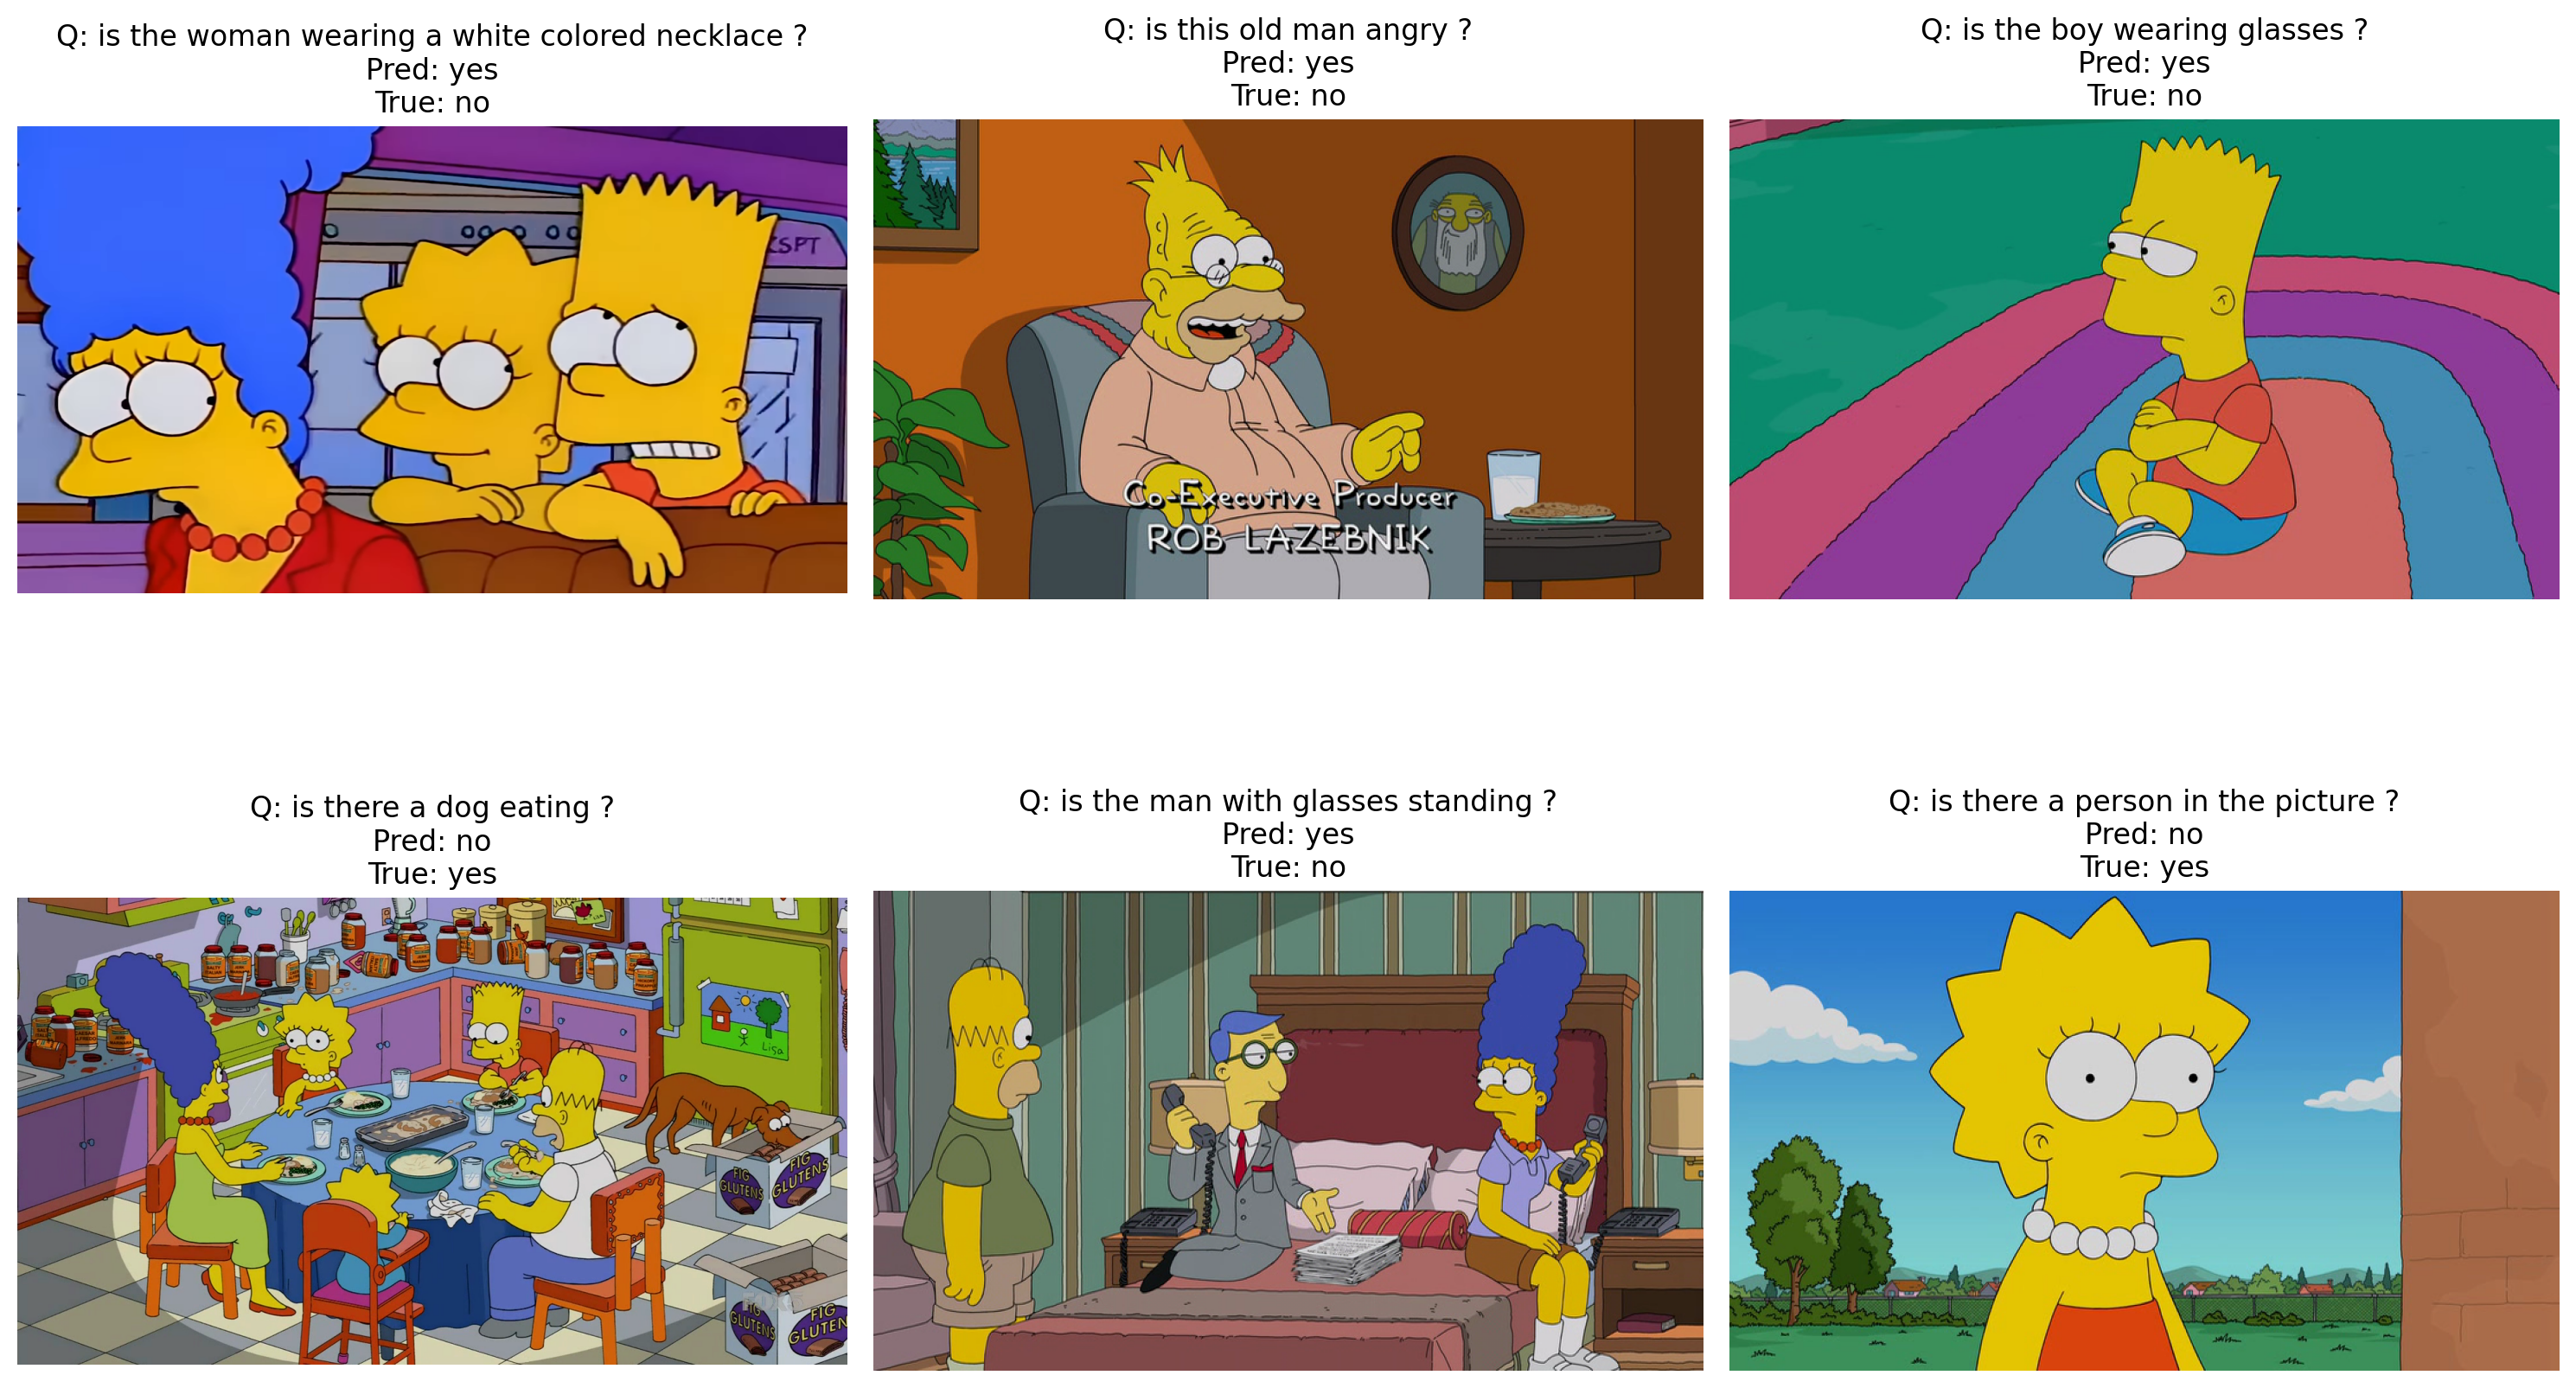

In [99]:
results = pd.DataFrame({"Prediction": y_predict, 
                        "Correct": anno_val, 
                        "Image File": imgs_val,
                        "Question": q_val})

# Apply the mapping to 'Prediction' and 'Correct' columns
incorrect = results[results['Prediction'] != results['Correct']]

# Select 9 random incorrect predictions
incorrect_sample = incorrect.sample(n=6)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=200)

# Flatten the 2D array 
axes = axes.flatten()

for i, ax in enumerate(axes[:6]):  
    row = incorrect_sample.iloc[i]
    img_path = row['Image File'] 
    img = np.array(Image.open(img_path))
    ax.imshow(img)
    ax.set_title(f"Q: {row['Question']}\nPred: {row['Prediction']}\nTrue: {row['Correct']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Save Final Model

In [98]:
# wandb.init()
# torch.save(model, 'model.pth')
# wandb.save("model.pth")
# art = wandb.Artifact(f'deakin-ai-blip-final', type="model")
# art.add_file("model.pth", "model.pth")
# wandb.log_artifact(art)